In [7]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit
import pickle

---

In [9]:
#First we read collected and already cleaned data
marburg = pd.read_csv("../data_0/marburg.csv")
duisburg = pd.read_csv("../data_0/duisburg.csv")
marburg_weather = pd.read_csv("../data_0/weather/marburg_weather.csv")
duisburg_weather = pd.read_csv("../data_0/weather/duisburg_weather.csv")

FileNotFoundError: [Errno 2] File ../data_0/marburg.csv does not exist: '../data_0/marburg.csv'

# KPIs

## Utilization / Peak Utilization (Anne)

In [61]:
#Read in data
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
fleet_size = len(marburg["b_number"].unique())
marburg

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins
datetime,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61
2019-07-06 20:11:00,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30
2019-07-07 08:47:00,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12
...,...,...,...,...,...,...,...,...,...
2019-05-19 12:57:00,2019-05-19,12:57:00,91116,marburg,"(50.8279, 8.7751)","(50.8137, 8.7707)",6,12,20
2019-05-19 21:41:00,2019-05-19,21:41:00,91116,marburg,"(50.8137, 8.7707)","(50.8229, 8.7747)",6,21,7
2019-05-20 06:56:00,2019-05-20,06:56:00,91116,marburg,"(50.8229, 8.7747)","(50.82, 8.7737)",0,6,3


In [ ]:
#setting start and end date of the trips (start is rounded down hourly)
marburg["start"] = marburg.index.floor(freq = "H")
marburg['end'] = marburg.index + pd.to_timedelta(marburg['trip_duration_mins'], unit='m')

In [85]:
#computing avaailablility by grouping by datetime and checking the number of diiferent bkie numbers
kpi["avail"]  = marburg.groupby("datetime")["b_number"].nunique()
kpi["avail"]

datetime
2019-01-20 00:04:00    1
2019-01-20 00:08:00    2
2019-01-20 00:25:00    1
2019-01-20 00:36:00    1
2019-01-20 00:38:00    1
                      ..
2020-01-20 22:50:00    1
2020-01-20 23:06:00    1
2020-01-20 23:16:00    1
2020-01-20 23:28:00    1
2020-01-20 23:45:00    1
Name: avail, Length: 124489, dtype: int64

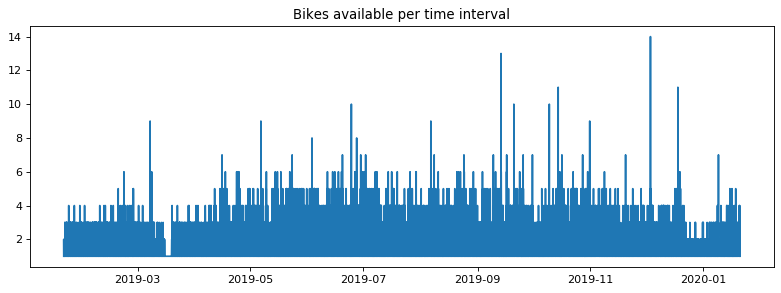

In [73]:
#plotting availability
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(kpi["avail"])
ax.set_title("Bikes available per time interval")
plt.show()

In [79]:
#creating day column
kpi["date"] = kpi.index.date
kpi

,avail,day,date
datetime,,,
2019-01-20 00:04:00,1,2019-01-20,2019-01-20
2019-01-20 00:08:00,2,2019-01-20,2019-01-20
2019-01-20 00:25:00,1,2019-01-20,2019-01-20
2019-01-20 00:36:00,1,2019-01-20,2019-01-20
2019-01-20 00:38:00,1,2019-01-20,2019-01-20
...,...,...,...
2020-01-20 22:50:00,1,2020-01-20,2020-01-20
2020-01-20 23:06:00,1,2020-01-20,2020-01-20
2020-01-20 23:16:00,1,2020-01-20,2020-01-20


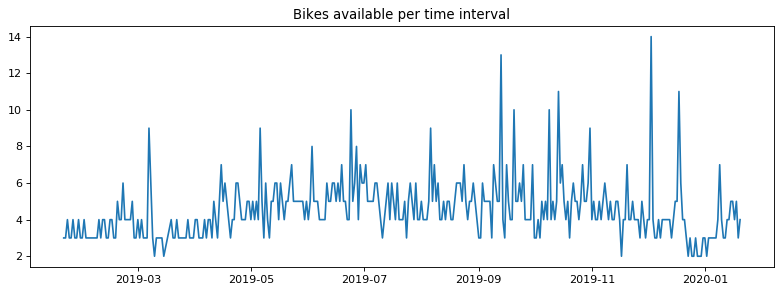

In [80]:
#computing max availaibility per day and plotting it
max_avail = kpi.groupby("date")["avail"].max()
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(max_avail)
ax.set_title("Maximum of bikes available per day")
plt.show()

## Fleet distance traveled (Tim)

Wer das hier liest ist cool :)

## Quality of fleet (Julia)

Another key performance indicator is the quality of the bikes.   
We can assume that if a bike is'nt used for 1 week or longer it is probably broken or can't be accessed.
The percentage of bikes that overstep this threshold value can tells us the quality of the fleet.

## Spread of fleet / coverage (Moritz)